In [4]:
import torch 
from torch import nn
from PIL import Image
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.transforms as transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torchvision import datasets
import os
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torchvision.models import resnet18, ResNet18_Weights
import sys
sys.path.append('/home/kadenw/Workspace/dog_scanner/dog_scanner')
from dog_scanner import (
    plot_loss_curves,
    train_step,
    test_step,
    train
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

sdogs_path = '/home/kadenw/Workspace/dog_scanner/data/stanford_dogs/images/Images'

IMAGE_SIZE = (224, 224)

aug_transform = transforms.Compose([
    transforms.Resize(size = IMAGE_SIZE),
    transforms.TrivialAugmentWide(), 
   #transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
orig_transform = transforms.Compose([
    transforms.Resize(size = IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data = datasets.ImageFolder(root = sdogs_path,
                            transform = orig_transform,
                            target_transform = None)
total_size = len(data)
train_size = int(total_size*0.8)
test_size = total_size-train_size
train_data, test_data = random_split(data, [train_size, test_size])

aug_train_data = Subset(datasets.ImageFolder(root=sdogs_path, 
                                       transform=aug_transform),
                                       train_data.indices)
comb = torch.utils.data.ConcatDataset([train_data, aug_train_data])

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 24

train_dataloader = DataLoader(dataset = comb, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

cuda


In [5]:
dog_scanner = resnet18(weights=ResNet18_Weights.DEFAULT)

for param in dog_scanner.parameters():
    param.requires_grad = False
for param in dog_scanner.layer4.parameters():
    param.requires_grad = True # Modify the final fully connected layer
dog_scanner.fc = nn.Sequential(
    nn.Linear(dog_scanner.fc.in_features, 512),  # Reduce to 512 neurons
    nn.ReLU(),
    nn.Dropout(0.5),  # Add dropout to reduce overfitting
    nn.Linear(512, len(data.classes))
)
dog_scanner.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Set number of epochs
epochs = 30

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=dog_scanner.parameters(), lr=0.00001, weight_decay=1e-3)

# Start the timer 
start_time = timer()

# Train model_0 
dog_scanner_results = train(model=dog_scanner, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=epochs,
                        device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9664 | train_acc: 0.7478 | test_loss: 0.8955 | test_acc: 0.0039
Epoch: 2 | train_loss: 0.8812 | train_acc: 0.7718 | test_loss: 0.8741 | test_acc: 0.0039
Epoch: 3 | train_loss: 0.8103 | train_acc: 0.7953 | test_loss: 0.8606 | test_acc: 0.0039
Epoch: 4 | train_loss: 0.7513 | train_acc: 0.8109 | test_loss: 0.8501 | test_acc: 0.0044
Epoch: 5 | train_loss: 0.6824 | train_acc: 0.8323 | test_loss: 0.8547 | test_acc: 0.0039
Epoch: 6 | train_loss: 0.6311 | train_acc: 0.8451 | test_loss: 0.8462 | test_acc: 0.0044
Epoch: 7 | train_loss: 0.5916 | train_acc: 0.8560 | test_loss: 0.8486 | test_acc: 0.0039


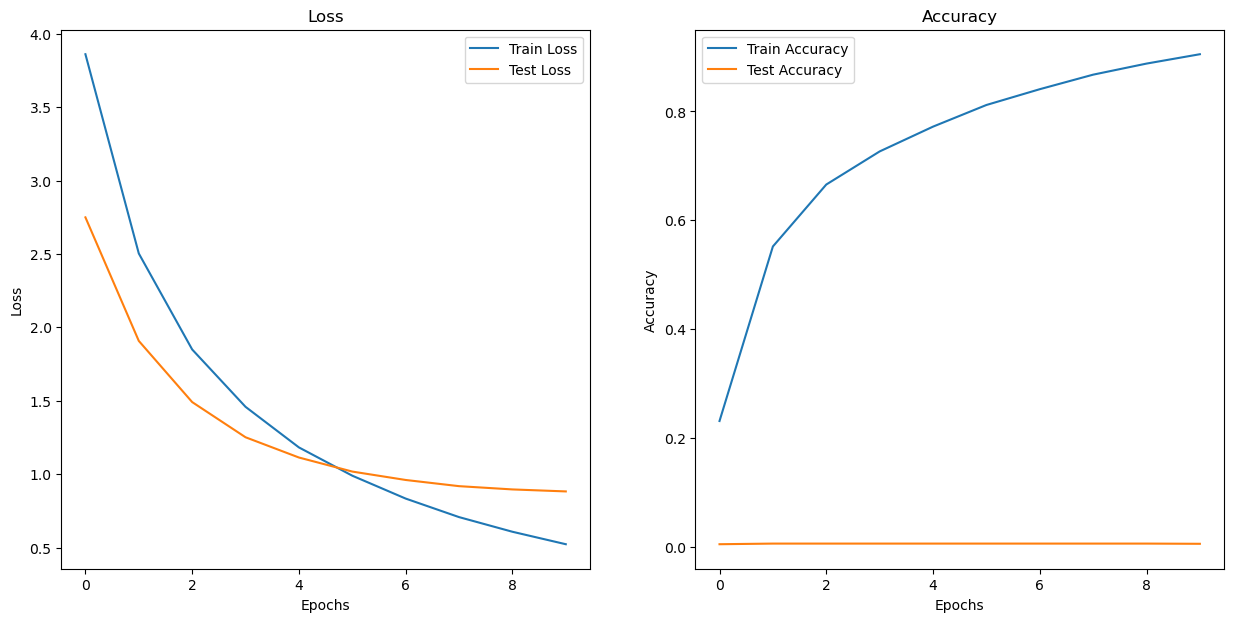

In [30]:
plot_loss_curves(dog_scanner_results)